# CMSC320 - Introduction to Data Science
## Final Tutorial
#### David Martin
---

**Introduction**
>Insert introduction here

**Imports**

The following is an import list of all the Python modules we use for the following tutorial, as well as some global styling settings.

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime 
import matplotlib.pyplot as plt
import requests
from sklearn.linear_model import LinearRegression
from fuzzywuzzy import process
from bs4 import BeautifulSoup
from datetime import date
plt.style.use('seaborn-whitegrid')

---
## Data Collection

The purpose of this section is to begin our analysis by collecting our data. We can find publicly available information about many things on government websites, I went to [Virginia's](https://data.virginia.gov) and found a great dataset of COVID reporting data organized by county. Lets use this as our main data set for this analysis.

Lets start by pulling the data from the dataset [VDH-COVID-19-PublicUseDataset-Cases](https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr) as found on data.virginia.gov, and taking a look at what it contains:

I cloned the dataset and put it in a [GitHub Repository](https://github.com/martindavid1995/Data-Science-Tutorial) in .csv format so that we can have a copy of the data without worrying about it changing on us in the future. We will use [Pandas](https://pandas.pydata.org/pandas-docs/stable/) to read from that .csv and put it into a DataFrame so that we can work with it.

In [83]:
# Pull data on COVID cases across Virginia
covid_data = pd.read_csv("https://raw.githubusercontent.com/martindavid1995/Data-Science-Tutorial/master/Covid_VA.csv")
# Display the first five entries
covid_data.head()

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths
0,03/17/2020,51001,Accomack,Eastern Shore,0,0,0
1,03/17/2020,51003,Albemarle,Thomas Jefferson,0,0,0
2,03/17/2020,51005,Alleghany,Alleghany,0,0,0
3,03/17/2020,51007,Amelia,Piedmont,0,0,0
4,03/17/2020,51009,Amherst,Central Virginia,0,0,0


In looking at this DataFrame, we see our listed columns. Right away we can see that we seem to have reports by county for a number of days which include total cases, hospitalizations, and deaths. Before ending this section, we might want to consider any more information that might be useful for us to get a good understanding of what COVID looks like in Virginia.

Since we will likely at some point be observing our data based on county, it might be helpful for us to get an idea of what counties have the largest and smallest populations. For example looking at death rate: three deaths in a single day in a Virginia county with a population of over 1 million people might mean significantly less than three deaths in a county with a population of 4,000 people. This is something we might want to consider when exploring our data, so we should attempt to find some population information for each county.

A google search of [Virginia Counties by Population](https://www.virginia-demographics.com/counties_by_population) brings us a chart with a value for each of Virginia's 133 counties. While we could sit here and manually enter the populations by hand, we can use python and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to strip the population data off this webpage so that we don't have to do all that manual data entry.

In [84]:
# Use requests to pull data from URL
r = requests.get("https://www.virginia-demographics.com/counties_by_population")
# Use BeautifulSoup to parse the request's HTML
soup = BeautifulSoup(r.content, 'html.parser')
# Find the table object and prettify it
table = soup.find('table').prettify()
# Convert the table into a DataFrame
populations = pd.read_html(str(table))[0]
# Drop the last row because it has data we don't need
populations = populations.drop(index=len(populations.index)-1)
# Display the first five entries
populations.head()

,Rank,County,Population
0,1,Fairfax County,1149439
1,2,Prince William County,466834
2,3,Virginia Beach city/county,450882
3,4,Loudoun County,405312
4,5,Chesterfield County,348500


Perfect! Now we have all of the data we are going to need for this analysis. We have our COVID reporting data, and we have our population sizes for each of our 133 Virginian counties. In the next section, we will begin manipulating these DataFrames so that we are able to have all the information we need to perform our data visualization.

---
## Data Management/Representation

In this section, we will begin modifying our data to contain the information that we need to perform our data visualization. Before we start changing things too much, lets try to get an idea of what our dataset looks like. We might ask to know how many rows of data do we have? What day does the data start and when does it end? Are all of the 133 counties in Virginia represented in our main dataset? Does each county have a report for each day? 

Lets start answering these questions by figuring out how many entries we have in our `covid_data` DataFrame.

In [85]:
print("Total number of columns in the dataset: ",len(covid_data.index))

Total number of columns in the dataset:  103607


So `covid_data` holds quite a bit of information. Over 100,000 rows where each row represents a single counties report on a given day. Next, lets try to see what the dates of the oldest and most recent reports are.

In [86]:
# Prints the minimum and maximum values of a specified column in a DataFrame
def printMinMax(df, column):
    print("Min: ",df[column].min())
    print("Max: ",df[column].max())
    
printMinMax(covid_data, "Report Date")

Min:  01/01/2021
Max:  12/31/2021


If we look at the results of the above cell, we notice our first issue with this dataset. The date range from the days above shows January 1, 2021 as being the earliest recorded date when we can clearly see from the head output in the above cells that we have columns with dates going back into 2020. This must be because there is some inability to compare these date objects in the current dataframe accurately. Lets convert the dates into DateTime objects so we can figure out our actual date range, and manipulate and visualize our data better.

In [87]:
# Split each date string into its components
def dateToDateTime(date: str):
    split = date.split("/")
    month = int(split[0])
    day = int(split[1])
    year = int(split[2])
    # Return a new DateTime object 
    return datetime.date(year, month, day)
    
# Convert each row's Report Date into a readable DateTime
def convertDateTime(df):
    datetimes = []
    for index in df.index:
        date = df.at[index, "Report Date"]
        datetimes.append(dateToDateTime(date))
    
    # Add the new DateTimes to the original DataFrame
    df['Time'] = datetimes
    return df

covid_data = convertDateTime(covid_data)

We can also go ahead and organize our columns and drop the ones we won't be needing.

In [88]:
# Drop columns that we don't need
covid_data = covid_data.drop(columns=['Report Date', 'FIPS', 'VDH Health District'])

# Reorder columns in a format that we prefer
cols = ['Time', 'Locality', 'Total Cases', 'Hospitalizations', 'Deaths']
covid_data = covid_data[cols]
covid_data.head()

,Time,Locality,Total Cases,Hospitalizations,Deaths
0,2020-03-17,Accomack,0,0,0
1,2020-03-17,Albemarle,0,0,0
2,2020-03-17,Alleghany,0,0,0
3,2020-03-17,Amelia,0,0,0
4,2020-03-17,Amherst,0,0,0


With the new DateTime column added, lets check to see what our actual date range looks like for this dataset.

In [89]:
printMinMax(covid_data, "Time")

Min:  2020-03-17
Max:  2022-05-04


Now we have a column with dates that we can actually compare in our data analysis. We can see that our data's report dates span from March 2020 to May 2022. Lets see what counties we have, how many dates are recorded, and see if each county has a report for each date.

In [90]:
# Get a list of the unique counties
counties = covid_data["Locality"].unique()
# Display how many unique counties are in our dataset
print("There are ",len(counties)," unique counties")

# Figure out how many unique dates we have data for
dates = covid_data["Time"].unique()
# Display how many unique dates we have
print("There are ",len(dates)," unique dates")

# Get the number of rows containing each unique date in our dataset
date_counts = covid_data["Time"].value_counts()
unique_dates = date_counts.unique()
# Display the unique date count values
print("Each date has ",unique_dates[0]," unique entries")

There are  133  unique counties
There are  779  unique dates
Each date has  133  unique entries


This above cell gives us a lot of great information. We now know that we have 133 Virginia counties whose COVID reporting data is in this dataset. We also know that each of the 133 counties has reported COVID data for each of the 779 dates recorded in this table. This is great news for us as it means there shouldn't be any missing data that we need to account for.

Unfortunately, the data provided from the Virginia website only records cumulative data. This means that instead of each county reporting their number of new cases, hospitalizations, and deaths each day, they only report the running total of cases they have in each category since reporting began. While this is important information, it might be useful for us to gather the new reported cases for each date. 

Having a daily report amount give us an easier way to visualize which dates have higher case, hospitalization, and death rates. We can use the difference in values between consecutive days in order to determine how many new cases are reported each day.

While we're at it, we should separate our DataFrames by county, since we will be looking at individual counties in our data analysis. Lets go ahead and do this manipulation.

In [91]:
# Takes a dataframe for a specific county and adds a column that shows the number of new cases reported for each report date
def genColumnDifference(df, column):
    offsets = []
    # For each row in the dataframe
    for index in df.index:
        if index == 0:
            offsets.append(0)
        else:
            # Compute the difference in the specified column of the current report date minus the previous report date
            offsets.append(df.at[index, column] - df.at[index-1, column])
    # Append this column to the dataframe
    df[column+" Per Day"] = offsets
    return df

county_frames = []
# For each county 
for county in counties:
    # Construct a new dataframe consisting only of rows corresponding to this county
    county_frame = covid_data.loc[covid_data["Locality"] == county]
    # Reset the indices
    county_frame = county_frame.reset_index(drop=True)
    # Get the column differences for Total Cases, Hospitalizations, and Deaths
    county_frame = genColumnDifference(county_frame, "Total Cases")
    county_frame = genColumnDifference(county_frame, "Hospitalizations")
    county_frame = genColumnDifference(county_frame, "Deaths")
    # Add it to our list of counties
    county_frames.append(county_frame)

county_frames[12].head()

,Time,Locality,Total Cases,Hospitalizations,Deaths,Total Cases Per Day,Hospitalizations Per Day,Deaths Per Day
0,2020-03-17,Brunswick,0,0,0,0,0,0
1,2020-03-18,Brunswick,0,0,0,0,0,0
2,2020-03-19,Brunswick,0,0,0,0,0,0
3,2020-03-20,Brunswick,0,0,0,0,0,0
4,2020-03-21,Brunswick,0,0,0,0,0,0


Now that we have the daily counts for each metric divided into separate DataFrames for each of our counties, we need to make sure we can easily pull the population counts for each county to help in our analysis. Ideally, we will define a function where we can pass in the `Locality` value from a row in the `covid_data` frame, and get the resulting population for that county out of our `populations` frame. 

Unfortunately, counties are do not have the same naming conventions between the two DataFrames. For example, if we are looking for the population for **"Fairfax"** as written in `covid_data`, its corresponding value is titled **"Fairfax County"** in the `populations` DataFrame. We need to modify these values so that we can use the same lookup key to easily access this information in the future. 

We can use this by using the Python library [FuzzyWuzzy](https://pypi.org/project/fuzzywuzzy/) to compute [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) between pairs of strings. We can then use these measures to match our county names in one frame to line them up with one another. We will find the best matching strings for these two columns and change the value in the `County` column in the `populations` frame to match its respective county in the `Locality` column in the `covid_data` frame.

In [92]:
# Get all of the counties from populations DataFrame in a list
pop_counties = populations['County'].unique()

# For each unique county name in our covid_data main DataFrame
for county in counties:
    # Use FuzzyWuzzy to find the value in the 'County' column of populations most similar to the value in the 'Locality' column in covid_data
    proc = process.extract(county, pop_counties, limit=1)
    # The match variable represents the matching county name in populations
    (match, score) = proc[0]
    # Get the index of that value in our populations frame
    index = populations.index[populations['County'] == match]
    # Rename the value in our populations frame so that it is identical to its respective county in in covid_data
    populations.at[index,'County'] = county
    
populations.head()

,Rank,County,Population
0,1,Fairfax,1149439
1,2,Prince William,466834
2,3,Virginia Beach,450882
3,4,Loudoun,405312
4,5,Chesterfield,348500


Lets quickly define a function to pull the population of any `Locality` from our main `covid_data` database. While we're at it, lets run a quick check to make sure we can pull a population value for each entry in our `covid_data` DataFrame. 

In [93]:
def getPopulation(county: str):
    return populations.loc[populations['County'] == county]['Population'].values[0]

In [94]:
# There is one county that doesn't match up in our populations DataFrame
for index in populations.index:
    # Find the bad county and manually fix it
    if populations.at[index, 'County'] == 'Charlotte County':
        populations.at[index, 'County'] = 'Charlottesville'
   


# Get the unique county names in each frame
population_counties = populations['County'].unique()
covid_data_counties = covid_data['Locality'].unique()
# Check for any that don't match
mismatched_values = 0
for ct in population_counties:
    if ct not in covid_data_counties:
        mismatched_values += 1

print("Found ",mismatched_values," mismatched values between our two DataFrames")

Found  0  mismatched values between our two DataFrames


Excellent! Now we can easily look up a counties population by just plugging in the `Locality` value in `covid_data` for that county.

Lets make sure that our `populations` frame is using data types that we can work with, and change them if needed.

In [95]:
populations.dtypes

Rank          object
County        object
Population    object
dtype: object

In [96]:
# We are going to need the Population column to be represented as an integer
populations = populations.astype({'Population':'int'})
populations.dtypes

Rank          object
County        object
Population     int32
dtype: object

Next, lets use our population data to obtain some per-capita values. We can simply divide the total number of cases, hospitalizations, and deaths for any given date by that particular counties population as saved in our `populations` DataFrame. Having per-capita values will allow us to standardize these counts across counties with varying populations and help us make a decision on if counties with populations have higher contraction rates.

In [97]:
# Returns the county name of a DataFrame
def getName(df):
    return df.iloc[0,1]

# 
def genPerCapita(df, column):
    newCol = []
    pop = getPopulation(getName(df))
    
    for index in df.index:
        newCol.append(df.at[index, column]/pop)
        
    df[column+' Per Capita'] = newCol
    return df

for county in county_frames:
    county = genPerCapita(county, 'Total Cases')
    county = genPerCapita(county, 'Hospitalizations')
    county = genPerCapita(county, 'Deaths')



Our county DataFrames now contain all of the information we need. Adding these per-capita measures allow us to see what percentage of each counties population has contracted COVID, or has been hospitalized, or has passed. This should do a lot to help us determine the COVID rates county by county. 

This concludes the **Data Management** section of the tutorial. Our data is now set up in a way where we can visualize it and perform some analysis. In the next section, we will begin doing just that.

---
## Exploratory Data Analysis

In this section, we will being visualizing and interpreting the COVID data for the state of Virginia. We will be using `Matplotlib` as our main visualization tool. 


Lets start by looking COVID data by simply plotting our `Total Cases` over time from our original dataset. We can use `Matplotlib` to achieve this rather easily. Let's first create a utility function to easily create a standard `Matplotlib.plot()`, and then plot `Total Cases` over `Time`

In [98]:
def makePlot(frame, x_col, y_col,title):
    # Create axes
    ax = plt.axes()
    
    # Extract and plot the values
    x = frame[x_col]
    y = frame[y_col]
    ax.plot(x,y)
        
    # Set labels and title
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title)
    # Rotate ticks
    plt.xticks(rotation=90)
    # Set the lower bound of the y-axis to 0
    plt.ylim(0)
    plt.show()


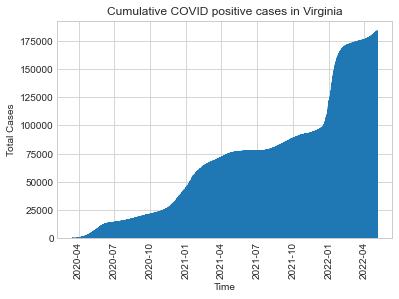

In [99]:
makePlot(covid_data, "Time", "Total Cases", "Cumulative COVID positive cases in Virginia")

As expected, the total number COVID cases in Virginia goes up over time. This is pretty intuitive as there is no way for the total cases to go down because it is a cumulative measure. From this chart we can gather some information about COVID contraction rates. We see two sections with steep slopes - January 2020 and January 2021 show massive relative spikes in total cases state-wide. This comes as no surprise, as the winter months involved cold/flu season as well as lots of family gatherings which might have increase the rate of spread.

In my opinion, plotting cases in this manner can be rather misleading. To me this chart make it look like COVID is getting way worse over time. From a glance, it could be misinterpreted to think that today there are way more people getting sick from COVID today than there were a last year simply because the most recent point on the graph will always be the highest point. To get an idea of seriously COVID is spreading at any point in time on the above chart, you must look at the slope at that point, and not the height of the point.

I think that it will be a lot more representative to see what the cases per day looks like if we want a better understanding of when COVID is at its worst in Virginia. Lets now plot the the `Total Cases Per Day` column as we computed previously across all counties to get a better view of the impact COVID has on Virginia residents. 

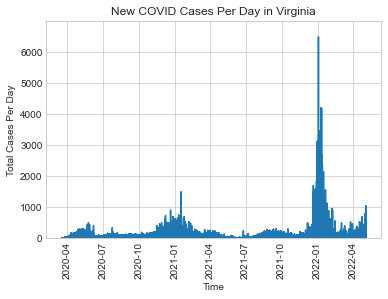

In [100]:
covid_data_enhanced = pd.concat(county_frames)
covid_data_enhanced = covid_data_enhanced.sort_values('Time', ascending=True)

makePlot(covid_data_enhanced, "Time", "Total Cases Per Day", "New COVID Cases Per Day in Virginia")

Now we have a much better picture of what COVID looks like in Virginia across time. From this chart we can see the same peaks in new cases that we saw in the previous chart - they're pretty significant. Between Dec. 2020 and January 2021, Virginia counties reported between 200-1000 new cases a day, with one spike day around 1500 new cases. As we move into April 2021, new cases significantly diminish and we see around July 2021 the number of new cases being reported in Virginia is very minimal. 

As we move into the end of 2021 and the beginning of 2022, we see a massive spike in new cases. During that period, we have a daily average of around 1500 cases with two spikes up to 6500 and about 4200 new cases every day. As compared to the spike in 2020/2021, this new spike is visibly way worse. From a glance, the second spike looks about three times as significant as the first.

We should take a moment to address the fact that an increase in cases reported does not neccesarily imply a **proportional** increase in people contracting the virus. There are many factors outside of actual virus contraction rates that could influence these values such as: availability of testing, increased awareness, mandatory testing requirements of institutions, and many others. While we do see a massive spike in cases reported some of this increase may be attributed to these reasons. As we continue our analysis we should keep this in mind.

Aside from these two spikes though, new cases remain relatively low in Virginia rarely passing above 100-200 a day. In a state with over 8.5 million residents, these numbers are very low. We can also see now a bit of a rise right towards the end of the graph, implying that we might be looking at beginnings of a new spike in cases right now. 

Not only does visualizing the data in this manner give us an insight on when COVID is spiking and when it isn't, it gives us a better visual representation that shows us how much larger the more recent surge was compared to the surge around Christmas time a year ago. 

Next, Lets take a look at hospitalization rates across all of Virginia.

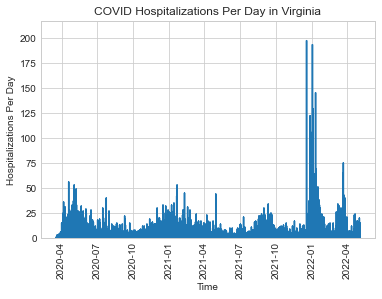

In [101]:
makePlot(covid_data_enhanced, "Time", "Hospitalizations Per Day", "COVID Hospitalizations Per Day in Virginia")

The hospitalizations per day over time match up similarly to the new cases per day. The values are significantly lower, but we can see very similar peaks around the winter months of the past two years as in the above visualization of cases. This comes as little surprise as if there are more people sick at a given time, we would expect to see more people hospitalized. We do notice, however, one discrepancy right towards the beginning of our data collection around April 2020 which shows a relatively large spike in hospitalizations. If we compare this section in the hospitalization chart with its corresponding section in the cases per day chart, it appears that the ratio of hospitalizations per cases towards the beginning of reporting was a bit higher than it is now. This is likely due to a lack in understanding of the severity of COVID. When there was little known about the pandemic there was likely a lower symptom threshold for hospitalizing a patient, as doctors simply didn't know well the average person could fight off the virus. 

The last thing we should assess when looking at the entirety of Virginia cases is the daily deaths. Lets plot that now.

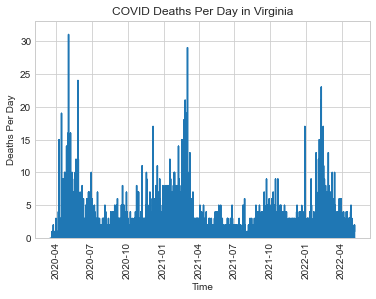

In [102]:
makePlot(covid_data_enhanced, "Time", "Deaths Per Day", "COVID Deaths Per Day in Virginia")

The deaths per day chart takes a bit of a departure from the above two plots. We see somewhat of a downward trend in daily deaths, especially when we consider the upward trend in new cases in hospitalizations when looking at the peaks. Despite the massive increase in cases and hospitalizations in the second winter peak as compared to the first, the number of deaths per day during the second peak is not consistent with this increase. From a glance we can see that the second peak appears to have roughly the same, if not slightly less deaths per day than the first peak.

This observation could be influenced by a number of factors. The first to consider would be what we stated above which was the fact that an increase in new cases reported does not neccesarily imply a **proportional** increase in people getting sick. Another factor would be medical research's ability to treat critical patients for the virus - as we understand more about how COVID impacts the body, medicine is bound to get more effective at treating sick patients which would likely increase survival rates. A third consideration would be the differences between virus variants. During January 2021 there was a belief that the Omicron variant was spreading rapidly and there was word that this variant was more contagious but had less of a physical impact on people. This claim would be supported by these charts showing that while many people were getting sick during the second surge, not a lot of people were dying. 

Virginia also saw a peak in reported deaths at the beginning of our dataset that was very similar to the peak seen during the first winter spike. While the cases were lower during this early reporting period, the deaths per day is fairly similar. This could be due to either underreporting of cases during this time, or a lower ability for doctors to treat high-risk patients with severe cases of the virus. Either way, when looking solely at the peak moments on this deaths per day chart while factoring in reported cases, over time the deadliness of COVID appears to be going down. 

To get a better idea of how the deadliness of COVID over time, lets do a little more data manipulation to observe of those who contracted COVID how many are dying.

In [103]:
# Reset our indices so we can iterate through the enhanced frame
covid_data_enhanced = covid_data_enhanced.reset_index(drop=True)
deaths_per_cases = []
# For each row in the enhanced frame
for index in covid_data_enhanced.index:
    # Scrape that row's Total Cases and Deaths values 
    cases = covid_data_enhanced.at[index, 'Total Cases']
    deaths = covid_data_enhanced.at[index, 'Deaths']
    # Avoid divide by 0
    if cases == 0:
        deaths_per_cases.append(0)
    # Low sample size cases significantly throw off values
    elif cases < 50:
        deaths_per_cases.append(np.nan)
    # Else append the ratio
    else:
        deaths_per_cases.append(deaths/cases)
# Append onto our enhanced frame
covid_data_enhanced['Deaths Per Cases'] = deaths_per_cases

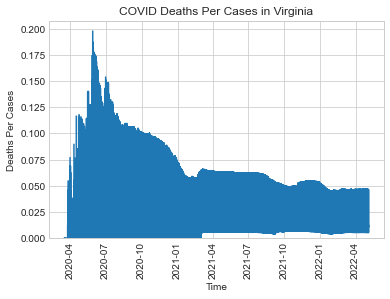

In [104]:
makePlot(covid_data_enhanced, "Time", "Deaths Per Cases", "COVID Deaths Per Cases in Virginia")

This final chart in this section confirms what we theorized in the previous charts which is that the deadliness of COVID in virginia has seemingly gone down over time. From April-June 2020 the death rate was the highest but has steadily followed a mild negative slope since then. This is good news for the future of COVID in Virginia because it predicts a decrease in the deadliness of the virus should it continue as it has been. This chart also shows that the peaks in COVID cases have little to no effect on the actual death rate, and that regardless of how rapidly COVID is spreading at any given time the chance of death remains fairly constant. 

From the visualizations of data in this section, we have been able to make the following observations about how COVID has impacted Virginia:
* There have been two major spikes in cases and hospitalizations since reporting began. One was during the winter of 2020/2021 and the other was during the winter of 2021/2022.
* While the second spike saw a massive increase in new cases reported as compared to the first, the second spike in cases saw an equal if not slightly lower death rate than the spike the year prior. 
* During the beginnings of our reported data in April 2020, we saw low reported cases with high hospitalizations and a relatively high death rate. 
* The deadliness of the virus has slightly decreased over time, with the highest deaths per cases being towards the beginning of the pandemic, and death rate gradually decreasing over time. 

This concludes our explatory data analysis section. During this section we have gathered a lot of insights onto COVID's effect on the state of Virginia. We will now move onto our next section which is hypothesis testing.

---
## Hypothesis Testing

In this section, we will attempt to answer the question: Does the population of a county have an effect on COVID case and death rates? In other words, are you more at risk of contracting and dying of COVID in a heavily populated county like Fairfax or Prince William than you would be if you lived in a remote county like Highland or Norton? Intuitively it might make sense to think that 

To test this hypothesis, we will collect data on the most and least populated counties in Virginia. From this data, we will do some visual plotting and perform some regression tests to check to see if there are noticeable differences in slopes.

We can start by grouping our `county_frames` data into lists based on population size.

In [105]:
# Define a function to get a a specific county's DataFrame
def getFrame(county: str):
    for frame in county_frames:
        if frame.iloc[0,1] == county:
            return frame

# Get the 5 largest and smallest rows out of populations by Population count
five_largest = populations.nlargest(10, ['Population'])['County'].to_list()
five_smallest = populations.nsmallest(10, ['Population'])['County'].to_list()

# These lists will hold our DataFrames for the counties with the smallest and largest populations
most_populous_frames = []
least_populous_frames = []

# Get list of frames
for cty in five_largest:
    most_populous_frames.append(getFrame(cty))
    
for cty in five_smallest:
    least_populous_frames.append(getFrame(cty))       


Now that we have our five most populous and least populous counties, lets make a line plot of each county in each list. This should allow us to see if there is a different trend in COVID contraction, hospitalization, and death rates based on county population. First, lets define a function to make plotting our data much easier so that we can visualize it without having to repeat a lot of code. 

In [106]:
# Takes a DataFrame, column values, and some titles to produce a matplotlib line plot
def makeLinePlot(df_list, x_col, y_col, x_title, title):
    ax = df_list[0].plot(x=x_col, y=y_col, label=getName(df_list[0]))
    for i in range (1, len(df_list)):
        df_list[i].plot(ax=ax, x=x_col, y=y_col, label=getName(df_list[i]))
    plt.xticks(rotation=90) 
    plt.xlabel(x_title)
    plt.ylabel(y_col)
    plt.title(title)   

C:\Users\marti\AppData\Local\Temp/ipykernel_23516/2737431356.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


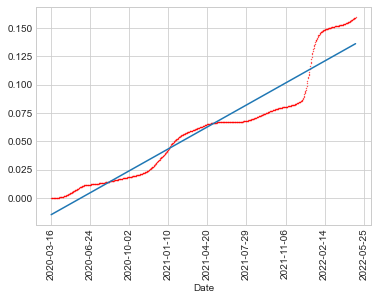

In [141]:
fairfax = most_populous_frames[0]
fairfax['date_ordinal'] = pd.to_datetime(fairfax['Time']).apply(lambda date: date.toordinal())
fix, ax = plt.subplots()
x = fairfax['date_ordinal']
y = fairfax['Total Cases Per Capita']
ax.scatter(x,y, s=0.1, c='r')
y = fairfax['Total Cases Per Capita']
x = fairfax['date_ordinal']
X = np.array(x)
Y = np.array(y)
model = LinearRegression().fit(X.reshape(-1,1),y)
ax.set_xlabel("Date")
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
x = np.linspace(x.min(),x.max(),100)
y = model.coef_[0]*x+model.intercept_
plt.xticks(rotation=90) 
plt.plot(x,y)

In [ ]:
# makeLinePlot(least_populous_frames, 'Time', 'Total Cases Per Capita', 'Date', 'Cases Per Capita Over Time: Least Populated Counties')